In [1]:
%loadext autoreload
%autoreload 2

UsageError: Line magic function `%loadext` not found.


In [2]:
import os
import torch
from srn.model import FuseNet, MainNet, SpatialRegularizationNet
from srn.util import processing_fn
from PIL import Image
import numpy as np
import pandas as pd
import heatmap
from skimage import io
from scipy import ndimage
from IPython.display import Image as ShowImage
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform

In [3]:
def _sigmoid(x):
    x = np.array(x)
    return 1 / (1 + np.exp(-x))

def show(image, att, weighted, alpha=0.6, display=False, save=None, cmap='viridis', axis='on', verbose=False):
    f, axarr = plt.subplots(1, 2, figsize=(12, 12))
    
    height = image.shape[0]
    width = image.shape[1]

    # resize heat map
    weighted_att_resized = transform.resize(weighted, (height, width))
    att_resized = transform.resize(att, (height, width))

    # normalize heat map
#     max_value = np.max(heat_map_resized)
#     min_value = np.min(heat_map_resized)
#     normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)
    max_value = np.concatenate([weighted_att_resized, att_resized]).max()
    weighted_att_resized[0, 0] = max_value
    att_resized[0, 0] = max_value

    # display
    axarr[0].imshow(image)
    axarr[0].imshow(255 * att_resized, alpha=alpha)
    axarr[0].axis(axis)
    
    axarr[1].imshow(image)
    axarr[1].imshow(255 * weighted_att_resized, alpha=alpha)
    axarr[1].axis(axis)

    if display:
        plt.show()

    if save is not None:
        if verbose:
            print('save image: ' + save)
        plt.savefig(save, bbox_inches='tight', pad_inches=0)

In [4]:
# Load label
label_path="data/pixta/5k/classes5k.csv"
all_labels = pd.read_csv(label_path).tags.tolist()
print("Total labels: ", len(all_labels))

Total labels:  5000


In [6]:
# Load model
# mainnet_ckpt = "data/pixta/5k/outs/mainnet_1581263513.1176987/checkpoint_net_57680.pth"
mainnet = MainNet(num_classes=len(all_labels))
# ckpt = torch.load(mainnet_ckpt, map_location="cpu")

# mainnet.load_state_dict(ckpt)
# mainnet.eval()

In [8]:
# Load attention model
att_model = SpatialRegularizationNet(mainnet)
att_ckpt = "data/pixta/5k/finetune_v2/att_1581816152.3045936/checkpoint_net_276879.pth"
ckpt = torch.load(att_ckpt, map_location="cpu")

att_model.load_state_dict(ckpt)
att_model.eval()
print("Attention model is loaded!")

Attention model is loaded!


In [28]:
# Load attention model
fuse = FuseNet(mainnet, att_model, mode="infer")
fuse_ckpt = "data/pixta/5k/finetune_v2/fuse_1581868969.8733113/checkpoint_net_69216.pth"
ckpt = torch.load(fuse_ckpt, map_location="cpu")

fuse.load_state_dict(ckpt)
fuse.eval()

srn = fuse.srn.eval()
main = fuse.mainnet.eval()
print("Fuse model is loaded!")

Fuse model is loaded!


In [10]:
testset = pd.read_csv("data/pixta/5k/test/data.csv")
test_items = testset.item_id.tolist()

In [35]:
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################

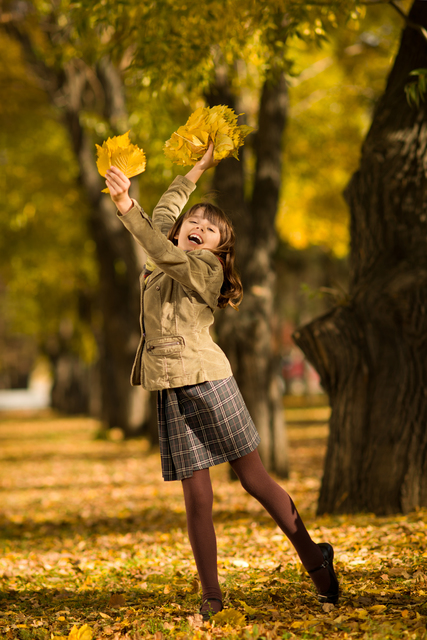

In [59]:
image_path = "/home/lab/pixta_data/tag_suggestion/classes10k/images/"
test_id = test_items[np.random.randint(len(test_items))]
# test_id = 14282535
test_image_path = os.path.join(image_path, "{}.jpg".format(test_id))
test_img = Image.open(test_image_path).convert("RGB")
img = processing_fn("test")(test_img).unsqueeze(dim=0)
img.shape
test_img

In [53]:
test_id

31399470

In [61]:
# Inference result
result = fuse(img).detach().numpy()[0]
# print(result)

top_5_idx = result.argsort()[-30:][::-1]
top_5_lbls = [all_labels[j] for j in top_5_idx]
top_5_confidence = [result[j] for j in top_5_idx]
# print("Confidences: ", _sigmoid(top_5_confidence))

# Visualize attention and weighted attention
feature_map = main.f_cnn(img)
attention_map = srn.att(feature_map)
confidence_map = srn.cnd(feature_map)
weighted_att = attention_map * torch.sigmoid(confidence_map)      # element-wise multiply

att_map = attention_map.detach().numpy()
weighted_att = weighted_att.detach().numpy()

print("Prediction labels:\n", "\n".join([str(t).strip() for t in list(zip(top_5_lbls, range(50), _sigmoid(top_5_confidence)))]).strip())
print("Total predictions:", (result>0).sum())

Prediction labels:
 ('autumn', 0, 0.9759152)
('fall', 1, 0.94440705)
('nature', 2, 0.9321735)
('happy', 3, 0.9047276)
('beautiful', 4, 0.89721435)
('young', 5, 0.8956086)
('park', 6, 0.89089155)
('child', 7, 0.8486921)
('girl', 8, 0.840762)
('yellow', 9, 0.79838204)
('kid', 10, 0.79120135)
('people', 11, 0.7907549)
('season', 12, 0.78105944)
('childhood', 13, 0.779356)
('portrait', 14, 0.77553314)
('person', 15, 0.77301395)
('beauty', 16, 0.76979387)
('healthy', 17, 0.7596186)
('cute', 18, 0.75586396)
('woman', 19, 0.7340452)
('fun', 20, 0.73077416)
('female', 21, 0.72128856)
('lifestyle', 22, 0.68015987)
('outdoor', 23, 0.66820455)
('face', 24, 0.6646097)
('outdoors', 25, 0.66105497)
('happiness', 26, 0.6444163)
('little', 27, 0.6388165)
('love', 28, 0.6319762)
('caucasian', 29, 0.6263306)
Total predictions: 43


Tags:  bikini


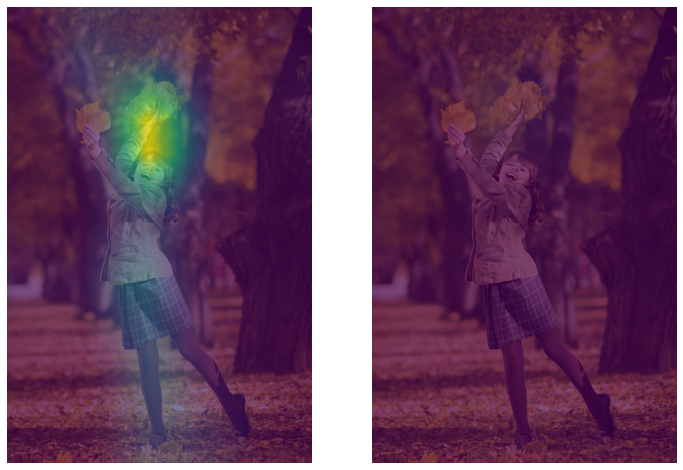

In [66]:
check_label = "bikini"
print("Tags: ", check_label)
image = io.imread(test_image_path)

# attention and weighted attention
att_label = np.squeeze(att_map[:, all_labels.index(check_label), :, :])
weighted_att_label = np.squeeze(weighted_att[:, all_labels.index(check_label), :, :])

att_heat_map = ndimage.filters.gaussian_filter(att_label, sigma=1)
weighted_heat_map = ndimage.filters.gaussian_filter(weighted_att_label, sigma=1)
show(image, att_heat_map, weighted_heat_map, alpha=0.7, axis='off')